In [2]:
import torch
import pickle

import pandas as pd
from models import GRUModel
import matplotlib.pyplot as plt
from solve_ca_ode import solve_ca
from run_bngl_avg import run_bionetgen_avg  # date April 11, 2025


In [3]:
NUM_FEATURES = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# ----------------------------
#      LOAD NORMALIZATION STATS
# ----------------------------
with open("input_scaler.pkl", "rb") as f:
    input_scaler = pickle.load(f)
with open("output_scaler.pkl", "rb") as f:
    output_scaler = pickle.load(f)

In [5]:
# ----------------------------
#      LOAD TRAINED MODEL
# ----------------------------
input_dim = 1
hidden_dim = 128
output_dim = 5
num_layers = 3
bidirectional = False
dropout = (
    0.1 if num_layers > 1 else 0.0
)  # dropout probability is the same for all layers regressors

model = GRUModel(
    input_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout
).to(device)
state_dict = torch.load(
    "intrinsic_Ca_model3.pth", map_location="cpu", weights_only=True
)
remove_prefix = "_orig_mod."
state_dict = {
    k[len(remove_prefix) :] if k.startswith(remove_prefix) else k: v
    for k, v in state_dict.items()
}
model.load_state_dict(state_dict)
model.eval()

fin_data = pd.read_csv("M_46L_50F.dat", sep="\t", comment="#", header=None)
fin_data_y = fin_data.iloc[:, 1].to_numpy().reshape(-1, 1)
test_data = input_scaler.transform(fin_data_y).reshape(1, fin_data.shape[0], 1)
input_tensor = torch.from_numpy(test_data).float().to(device)

# ----------------------------
#     MAKE PREDICTION
# ----------------------------
with torch.no_grad():
    pred_output_tensor = model(input_tensor)

estimates = pred_output_tensor.cpu().numpy()
estimates = output_scaler.inverse_transform(estimates)[0]
print(estimates)

[1.0006172e-04 2.8203759e-01 5.7595238e+05 1.8710960e+00 1.0001522e-04]


In [46]:
kon = estimates[0]
koff = estimates[1]
C1 = estimates[2]
C2 = estimates[3]
g = estimates[4]
# kon=0.0002673049082510339
# koff=0.010551230151439562
# C1=177915.28609619488
# C2=2.1640109518946167
# g=0.005120023560695736
print(f"kon={kon}")
print(f"koff={koff}")
print(f"C1={C1}")
print(f"C2={C2}")
print(f"g={g}")

kon=0.00010006171942222863
koff=0.2820375859737396
C1=575952.375
C2=1.8710960149765015
g=0.00010001521877711639


 (SSR error)**0.25 = 1948.3247634681036


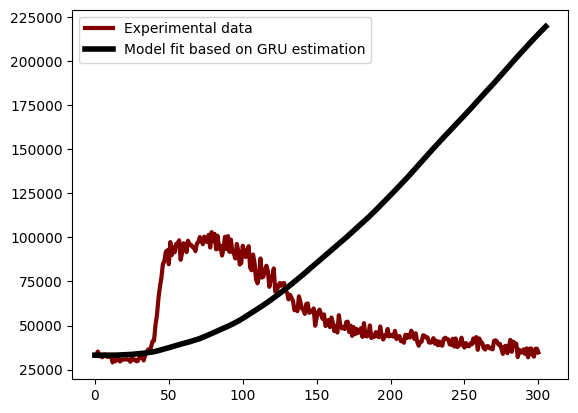

In [47]:
# Loading the experimental data file : Maitreya
n = 1 # averaging over 3  trajectories : John/ MAITREYA you can change this
p = 1  # 2nd column in the file: pZAP is printed on the first column, time is printed on the zeroth column

time, mean_pZAP = run_bionetgen_avg(n, p, kon, koff)  # [0, 300]

tnew, ca = solve_ca(
    time, mean_pZAP, kon, koff, C1, C2, g, fin_data.iloc[:, 0], fin_data.iloc[:, 1]
)  # solving the ODEs
# tnew, ca = solve_ca(time, mean_pZAP, C1, C2, g)  # solving the ODEs

# plot
plt.plot(fin_data.iloc[:, 0], fin_data.iloc[:, 1], color="maroon", linewidth=3, label="Experimental data")
plt.plot(tnew, ca, color="black", linewidth=4, label="Model fit based on GRU estimation")
plt.legend()
plt.show()